In this notebook, we will run a ready-made network starting from some ATLAS data. There is also an alternative to train the network from scratch.

## Look into the dataset

We load the dataset 'monojet_Zp2000.0_DM_50.0_chan3.csv' from the current directory and preprocess it.

In [1]:
# Load dataset

import numpy as np
import pandas as pd

# Read the whole csv using pandas, fill the missing elements with None
dataset = pd.DataFrame([line.strip().split(';') for line in open('monojet_Zp2000.0_DM_50.0_chan3.csv', 'r')])
# Convert the dataset into a np array for easy slicing and filtering
dataset = dataset.values
# Remove the first 5 columns of the dataset and convert the dataset into a 1D array
# Now the datasets contains the data points, None values, and empty strings
dataset = dataset[:,5:].reshape(-1)
# Remove the None values and empty strings
dataset = dataset[dataset != None]
dataset = dataset[dataset != '']
# Since every data point is one single string, split them as a list of strings based on the commas
dataset = np.array([data.split(',') for data in dataset])
# Remove the non-jet datapoints
dataset = dataset[dataset.T[0] == 'j']
# Remove the first columns of 'j' and convert the data values into floats
dataset = dataset.T[1:].T.astype(float)
# Store the dataset as a pandas DataFrame with corresponding labels
dataset = pd.DataFrame(dataset, columns=['E', 'pt', 'eta', 'phi'])

In [2]:
# normalize the dataset

# this function is based on the custom_unnormalize function defined in the original file
def custom_normalize(df):
    df['eta'] = df['eta'] / 5
    df['phi'] = df['phi'] / 3
    df['E'] = np.log10(df['E'])
    #df['m'] = np.log10(df['m'])
    df['pt'] = np.log10(df['pt'])
    return df

dataset = custom_normalize(dataset)

In [3]:
# Use the first 4/5 of the data as the training set
train = dataset[:(22661*4//5)]
# Use the last 1/5 of the data as the testing set
test = dataset[(22661*4//5):]

# To get an idea of the order of magnitude we are going to see in the plots we show the first elements 
# in the samples:
print('Training sample:')
print(train.head())

print('\n')

print('Testing sample:')
print(test.head())

print('\n')

print('The number of entries in the training data:', len(train))
print('The number of entries in the validation data:', len(test))

Training sample:
          E        pt       eta       phi
0  5.412833  5.386811  0.065792  0.750047
1  5.716080  5.035790 -0.449460 -0.618930
2  5.583226  4.946480  0.429032 -0.652117
3  4.596681  4.548575  0.094092 -0.388150
4  5.353012  4.429400 -0.563216 -0.753127


Testing sample:
              E        pt       eta       phi
18128  4.500611  4.493988 -0.006970 -0.354950
18129  6.086566  5.750889  0.281522  0.591603
18130  5.264320  5.159188 -0.142921 -0.546207
18131  5.021334  4.486637 -0.380098  0.314955
18132  5.661640  5.519049 -0.168007  0.299902


The number of entries in the training data: 18128
The number of entries in the validation data: 4533


Now we plot the data using the matplotlib library. The units reflect the normalization, but it's the shape that we care about. 

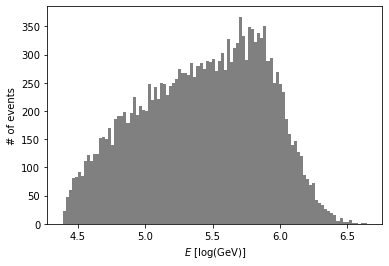

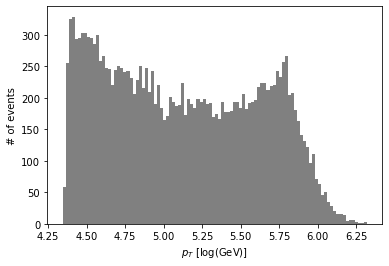

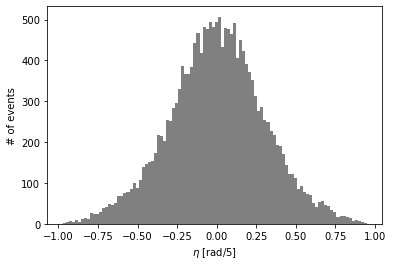

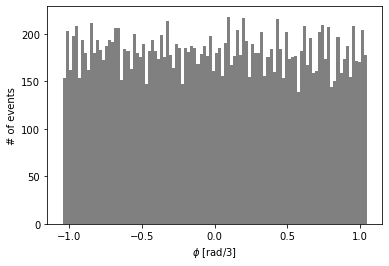

In [4]:
import matplotlib.pyplot as plt

unit_list = ['[log(GeV)]', '[log(GeV)]', '[rad/5]', '[rad/3]']
variable_list = [r'$E$', r'$p_T$', r'$\eta$', r'$\phi$']

branches=["E", "pt","eta","phi"]

n_bins = 100

for kk in range(0,4):
    n_hist_data, bin_edges, _ = plt.hist(train[branches[kk]], color='gray', label='Input', alpha=1, bins=n_bins)
    plt.xlabel(xlabel=variable_list[kk] + ' ' + unit_list[kk])
    plt.ylabel('# of events')
    #plt.savefig("fourmomentum_"+branches[kk],dpi=300)
    plt.show()

## Setting up the network

### Preparing the data

Adding the two datasets as TensorDatasets to PyTorch (also loading all other classes we'll need later)

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
from torch.autograd import Variable

from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

from fastai import learner
from fastai.data import core

train_x = train
test_x = test
train_y = train_x  # y = x since we are building an autoencoder
test_y = test_x

# Constructs a tensor object of the data and wraps them in a TensorDataset object.
train_ds = TensorDataset(torch.tensor(train_x.values, dtype=torch.float), torch.tensor(train_y.values, dtype=torch.float))
valid_ds = TensorDataset(torch.tensor(test_x.values, dtype=torch.float), torch.tensor(test_y.values, dtype=torch.float))

We now set things up to load the data, and we use a batch size that was optimized by previous students...note also that this is fastai v2, migration thanks to Jessica Lastow.

In [6]:
bs = 256

# Converts the TensorDataset into a DataLoader object and combines into one DataLoaders object (a basic wrapper
# around several DataLoader objects). 
train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=bs * 2)
dls = core.DataLoaders(train_dl, valid_dl)

### Preparing the network

Here we have an example network. Details aren't too important, as long as they match what was already trained for us...in this case we have a LeakyReLU, tanh activation function, and a number of layers that goes from 4 to 200 to 20 to 3 (number of features in the hidden layer that we pick for testing compression) and then back all the way to 4. 

In [7]:
class AE_3D_200_LeakyReLU(nn.Module):
    def __init__(self, n_features=4):
        super(AE_3D_200_LeakyReLU, self).__init__()
        self.en1 = nn.Linear(n_features, 200)
        self.en2 = nn.Linear(200, 200)
        self.en3 = nn.Linear(200, 20)
        self.en4 = nn.Linear(20, 3)
        self.de1 = nn.Linear(3, 20)
        self.de2 = nn.Linear(20, 200)
        self.de3 = nn.Linear(200, 200)
        self.de4 = nn.Linear(200, n_features)
        self.tanh = nn.Tanh()

    def encode(self, x):
        return self.en4(self.tanh(self.en3(self.tanh(self.en2(self.tanh(self.en1(x)))))))

    def decode(self, x):
        return self.de4(self.tanh(self.de3(self.tanh(self.de2(self.tanh(self.de1(self.tanh(x))))))))

    def forward(self, x):
        z = self.encode(x)
        return self.decode(z)

    def describe(self):
        return 'in-200-200-20-3-20-200-200-out'

#model = AE_3D_200_LeakyReLU().double()
model = AE_3D_200_LeakyReLU()
model.to('cpu')

AE_3D_200_LeakyReLU(
  (en1): Linear(in_features=4, out_features=200, bias=True)
  (en2): Linear(in_features=200, out_features=200, bias=True)
  (en3): Linear(in_features=200, out_features=20, bias=True)
  (en4): Linear(in_features=20, out_features=3, bias=True)
  (de1): Linear(in_features=3, out_features=20, bias=True)
  (de2): Linear(in_features=20, out_features=200, bias=True)
  (de3): Linear(in_features=200, out_features=200, bias=True)
  (de4): Linear(in_features=200, out_features=4, bias=True)
  (tanh): Tanh()
)

We now have to pick a loss function - MSE loss is appropriate for a compression autoencoder since it reflects the [(input-output)/input] physical quantity that we want to minimize. 

In [8]:
from fastai.metrics import mse

loss_func = nn.MSELoss()

#bn_wd = False  # Don't use weight decay for batchnorm layers
#true_wd = True  # weight decay will be used for all optimizers
wd = 1e-6

recorder = learner.Recorder()
learn = learner.Learner(dls, model=model, wd=wd, loss_func=loss_func, cbs=recorder)
#was: learn = basic_train.Learner(data=db, model=model, loss_func=loss_func, wd=wd, callback_fns=ActivationStats, bn_wd=bn_wd, true_wd=true_wd)

## Alternative 1: Running a pre-trained network

Now we load the pre-trained network. 

In [ ]:
learn.load("Trained_model")

Then we evaluate the MSE on this network - it should be of the order of 0.001 or less if all has gone well...if it has not trained as well (note the pesky 0-mass peak above...) then it's going to be a bit higher.

In [ ]:
learn.validate()

## Alternative 2: Training a new network

Instead of using a pre-trained network, an alternative is to train a new network and use that instead. 

First, we want to find the best learning rate. The learning rate is a hyper-paramater that sets how much the weights of the network will change each step with respect to the loss gradient.

Then we plot the loss versus the learning rates. We're interested in finding a good order of magnitude of learning rate, so we plot with a log scale.

A good value for the learning rates is then either:
- one tenth of the minimum before the divergence
- when the slope is the steepest

Learning rate with the minimum loss: 0.012022644281387329
Learning rate with the steepest gradient: 0.002511886414140463


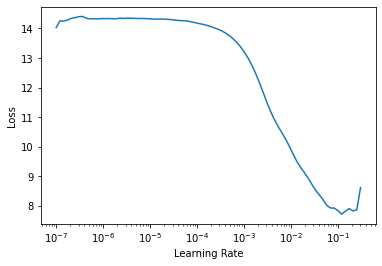

In [9]:
from fastai.callback import schedule

lr_min, lr_steep = learn.lr_find()

print('Learning rate with the minimum loss:', lr_min)
print('Learning rate with the steepest gradient:', lr_steep)

Now we want to run the training!

User-chosen variables:
- n_epoch: The number of epochs, i.e how many times the to run through all of the training data once (i.e the 1266046 entries, see cell 2)
- lr: The learning rate. Either choose lr_min, lr_steep from above or set your own.


In [10]:
import time

start = time.perf_counter() # Starts timer
learn.fit_one_cycle(100, lr_min)
end = time.perf_counter() # Ends timer
delta_t = end - start
print('Training took', delta_t, 'seconds')

[0, 1.9614285230636597, 0.30916401743888855, '00:00']
[0, 1.9614285230636597, 0.30916401743888855, '00:00']
[1, 0.5769878625869751, 0.22853954136371613, '00:00']
[1, 0.5769878625869751, 0.22853954136371613, '00:00']
[2, 0.30791419744491577, 0.2265290468931198, '00:00']
[2, 0.30791419744491577, 0.2265290468931198, '00:00']
[3, 0.24661360681056976, 0.2253795564174652, '00:00']
[3, 0.24661360681056976, 0.2253795564174652, '00:00']
[4, 0.2339688390493393, 0.2285943627357483, '00:00']
[4, 0.2339688390493393, 0.2285943627357483, '00:00']
[5, 0.22993509471416473, 0.2248883843421936, '00:00']
[5, 0.22993509471416473, 0.2248883843421936, '00:00']
[6, 0.17508232593536377, 0.1378968358039856, '00:00']
[6, 0.17508232593536377, 0.1378968358039856, '00:00']
[7, 0.1162242591381073, 0.04929599538445473, '00:00']
[7, 0.1162242591381073, 0.04929599538445473, '00:00']
[8, 0.05908437445759773, 0.03805335983633995, '00:00']
[8, 0.05908437445759773, 0.03805335983633995, '00:00']
[9, 0.04671584069728851, 0.0

[72, 0.00036670611007139087, 0.00016501237405464053, '00:00']
[72, 0.00036670611007139087, 0.00016501237405464053, '00:00']
[73, 0.0005322382785379887, 0.00021640723571181297, '00:00']
[73, 0.0005322382785379887, 0.00021640723571181297, '00:00']
[74, 0.00025100840139202774, 0.0002237713197246194, '00:00']
[74, 0.00025100840139202774, 0.0002237713197246194, '00:00']
[75, 0.00023492884065490216, 0.0002045426663244143, '00:00']
[75, 0.00023492884065490216, 0.0002045426663244143, '00:00']
[76, 0.0002259788743685931, 0.0002097021060762927, '00:00']
[76, 0.0002259788743685931, 0.0002097021060762927, '00:00']
[77, 0.00016208499437198043, 0.00017982629651669413, '00:00']
[77, 0.00016208499437198043, 0.00017982629651669413, '00:00']
[78, 0.00015871749201323837, 0.00014759555051568896, '00:00']
[78, 0.00015871749201323837, 0.00014759555051568896, '00:00']
[79, 0.0001214752919622697, 8.838015492074192e-05, '00:00']
[79, 0.0001214752919622697, 8.838015492074192e-05, '00:00']
[80, 0.000110565801151

Then we plot the loss as a function of batches and epochs to check if we reach a plateau.

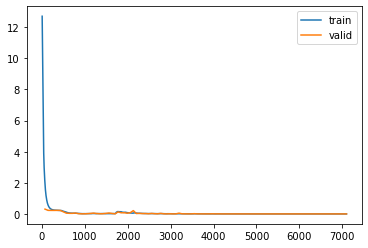

In [11]:
recorder.plot_loss()

Then we evaluate the MSE on this network - it should be of the order of 0.001 or less if all has gone well...if it has not trained as well (note the pesky 0-mass peak above...) then it's going to be a bit higher.

In [12]:
learn.validate()

(#1) [2.907554153352976e-05]

We can save this model.

In [13]:
learn.save("Trained_model")

Path('models/Trained_model.pth')

Let's plot all of this, with ratios (thanks to code by Erik Wallin)

## Plotting the outputs of the network

Lazy-save of our output files (they'll also be on screen)

In [14]:
import os
save_dir = "plotOutput"
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

A function in case we want to un-normalize and get back to physical quantities...

In [15]:
def custom_unnormalize(df):
    df['eta'] = df['eta'] * 5
    df['phi'] = df['phi'] * 3
    df['E'] = 10**df['E']
    #df['m'] = 10**df['m']
    df['pt'] = 10**(df['pt'])
    return df

Make the histograms from the dataset...

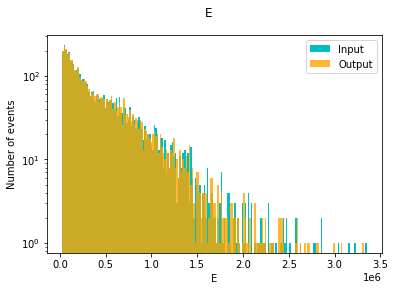

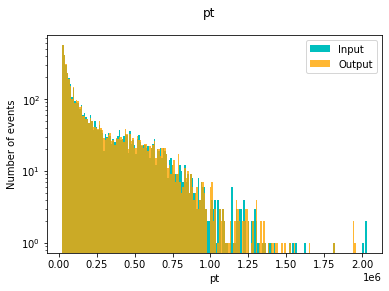

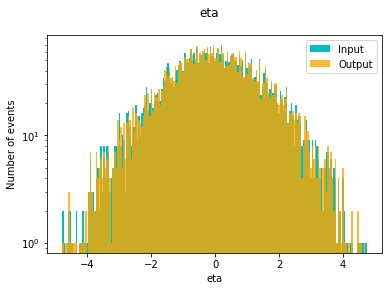

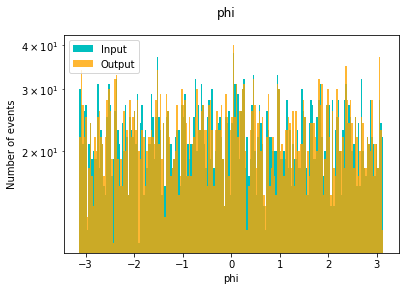

In [16]:
import numpy as np

plt.close('all')
unit_list = ['[GeV]', '[rad]', '[rad]', '[GeV]']
variable_list = [r'$p_T$', r'$\eta$', r'$\phi$', r'$E$']
line_style = ['--', '-']
colors = ['orange', 'c']
markers = ['*', 's']

model.to('cpu')

save = True # Option to save figure

# Histograms
idxs = (0, 100000)  # Choose events to compare
data = torch.tensor(test[idxs[0]:idxs[1]].values, dtype=torch.float)
#data = torch.tensor(test[idxs[0]:idxs[1]].values, dtype=torch.float).double()
pred = model(data)
pred = pred.detach().numpy()
data = data.detach().numpy()

data_df = pd.DataFrame(data, columns=test.columns)
pred_df = pd.DataFrame(pred, columns=test.columns)

unnormalized_data_df = custom_unnormalize(data_df)
unnormalized_pred_df = custom_unnormalize(pred_df)    
    
alph = 0.8
n_bins = 200
for kk in np.arange(4):
    plt.figure()
    n_hist_data, bin_edges, _ = plt.hist(data[:, kk], color=colors[1], label='Input', alpha=1, bins=n_bins)
    n_hist_pred, _, _ = plt.hist(pred[:, kk], color=colors[0], label='Output', alpha=alph, bins=bin_edges)
    plt.suptitle(test.columns[kk])
    plt.xlabel(test.columns[kk])
    plt.ylabel('Number of events')
    # ms.sciy()
    plt.yscale('log')
    if save:
        plt.savefig(os.path.join(save_dir,test.columns[kk]+'.png'))
    plt.legend()

In [17]:
def getRatio(bin1,bin2):
    bins = []
    for b1,b2 in zip(bin1,bin2):
        if b1==0 and b2==0:
            bins.append(0.)
        elif b2==0:
            bins.append(None)
        else:
            bins.append((float(b2)-float(b1))/b1)
    return bins   

rat = getRatio(n_hist_data,n_hist_pred)
#print(rat)